## サンプラー:blackjax サンプル数=1000 尤度(目的関数の分布:StudentT分布)  
観測データ数を200→1000に変更して結果が変わるか確認する

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import numpyro

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#graphvizを使うためPATHを設定
import os
# Replace 'path_to_graphviz_bin' with the actual path to your Graphviz 'bin' directory.
# 仮想環境名が通常のPymc環境(/opt/conda/envs/pymc-dev/bin/)と違うため注意
graphviz_bin_path = '/opt/conda/envs/pymc-test/bin/'
# Append the Graphviz 'bin' directory to the PATH.
os.environ["PATH"] += os.pathsep + graphviz_bin_path

(array([302., 242., 203., 121.,  67.,  34.,  20.,   6.,   4.,   1.]),
 array([1.13768319e-03, 3.75903283e-01, 7.50668884e-01, 1.12543448e+00,
        1.50020008e+00, 1.87496568e+00, 2.24973128e+00, 2.62449688e+00,
        2.99926249e+00, 3.37402809e+00, 3.74879369e+00]),
 <BarContainer object of 10 artists>)

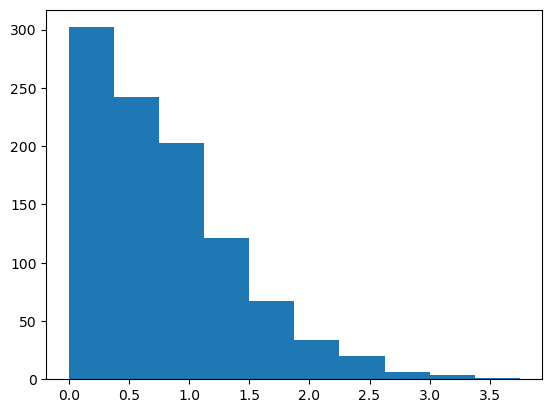

In [3]:
#標準偏差:1の半正規分布をサンプリング
temp1 = pm.HalfNormal.dist(sigma=1,shape=(1000,))
a1_true = pm.draw(temp1)

plt.hist(a1_true)

In [4]:
a1_true.shape

(1000,)

(array([  3.,  26.,  78., 157., 250., 241., 155.,  71.,  15.,   4.]),
 array([-3.22859353, -2.57567189, -1.92275024, -1.2698286 , -0.61690695,
         0.0360147 ,  0.68893634,  1.34185799,  1.99477963,  2.64770128,
         3.30062293]),
 <BarContainer object of 10 artists>)

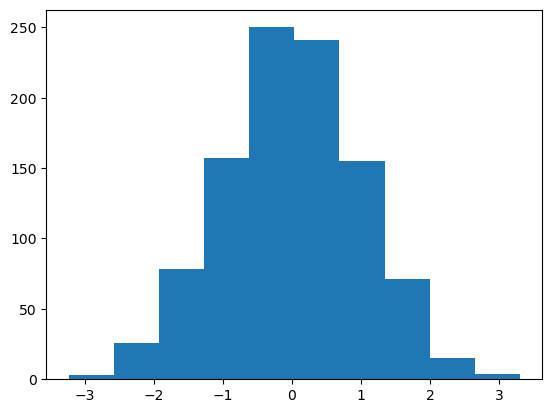

In [5]:
#標準偏差:1の正規分布をサンプリング
temp2 = pm.Normal.dist(sigma=1,shape=(1000,))
a2_true = pm.draw(temp2)

plt.hist(a2_true)

(array([279., 237., 201., 133.,  87.,  33.,  22.,   2.,   2.,   4.]),
 array([2.23371560e-03, 3.66123223e-01, 7.30012731e-01, 1.09390224e+00,
        1.45779175e+00, 1.82168125e+00, 2.18557076e+00, 2.54946027e+00,
        2.91334978e+00, 3.27723929e+00, 3.64112879e+00]),
 <BarContainer object of 10 artists>)

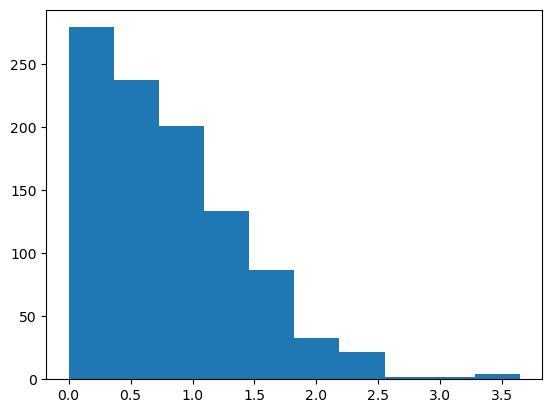

In [6]:
#標準偏差:1の半正規分布をサンプリング 誤差項
temp3 = pm.HalfNormal.dist(sigma=1,shape=(1000,))
intercept_true = pm.draw(temp3)

plt.hist(intercept_true)

In [7]:
pd.DataFrame({'a1_true':a1_true,'a2_true':a2_true,'intercept_true':intercept_true})

,a1_true,a2_true,intercept_true
0,0.066717,-0.978587,0.601691
1,0.044306,0.678228,0.470638
2,2.614211,1.517365,3.170301
3,0.313884,0.989646,0.682565
4,0.202599,-0.131929,1.370868
...,...,...,...
995,1.037222,0.574572,0.464858
996,0.827502,0.855419,0.046177
997,0.080984,0.471119,0.326321
998,0.887691,0.873124,0.363453


## 考え方  
a1_trueは半正規分布からサンプルした200の値　a2_trueは正規分布からサンプルした200の値  
↑が推定したい事前分布  
次に2×200行の一様分布からサンプルした特徴量を生成する(いわゆる観測できる値)

In [8]:
# 下限0,上限1の一様分布から200個サンプル
temp3 = pm.Uniform.dist(lower=0, upper=1,shape=(1000,))
temp4 = pm.Uniform.dist(lower=0, upper=1,shape=(1000,))
x1 = pm.draw(temp3)
x2 = pm.draw(temp4)

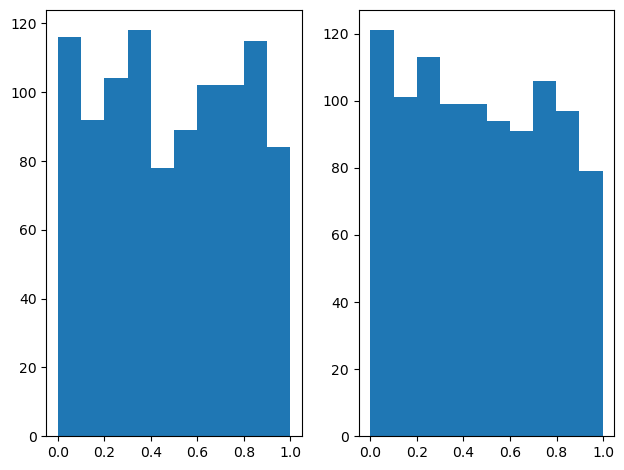

In [9]:
# 作成したx1,x2を可視化
fig ,ax = plt.subplots(1,2)
ax[0].hist(x1)
ax[1].hist(x2)
fig.tight_layout()

In [10]:
# 真の値を利用した目的変数を作成　変数複数
y = x1 *a1_true + x2 *a2_true + intercept_true

In [13]:
y.shape

(1000,)

(array([ 15.,  53., 235., 337., 212., 102.,  32.,  12.,   1.,   1.]),
 array([-1.48861839, -0.75530851, -0.02199864,  0.71131123,  1.44462111,
         2.17793098,  2.91124085,  3.64455072,  4.3778606 ,  5.11117047,
         5.84448034]),
 <BarContainer object of 10 artists>)

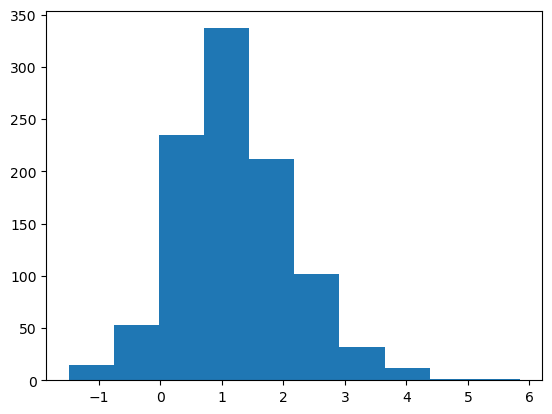

In [14]:
plt.hist(y)

In [15]:
df1 = pd.DataFrame({'x1':x1,'x2':x2, 'y':y})

In [16]:
# 観測できているデータを確認
df1

,x1,x2,y
0,0.785937,0.777546,-0.106770
1,0.905485,0.072103,0.559659
2,0.199534,0.111979,3.861838
3,0.300559,0.227705,1.002254
4,0.639091,0.669519,1.412018
...,...,...,...
995,0.901085,0.799282,1.858729
996,0.278639,0.777861,0.942148
997,0.059302,0.611508,0.619217
998,0.623062,0.317206,1.193500


## モデル1を作成  
x1には半正規分布の事前分布を設定  
x２には正規分布の事前分布を設定  
y(尤度)はStudentT分布にする

In [17]:
df_x1=df1['x1']
df_x2=df1['x2']
df_y =df1['y']

In [18]:
model1 = pm.Model()

In [19]:
with model1:
    #観測データを定義
    model1.add_coord('data',df_x1.index, mutable=True)
    model1.add_coord('var',df1.columns, mutable=True)
    x1_data= pm.Data("x1_data", df_x1, dims=('data'), mutable=True)
    x2_data= pm.Data("x2_data", df_x2, dims=('data'), mutable=True)
    y_data = pm.Data("y_data", df_y, dims=('data'), mutable=True)

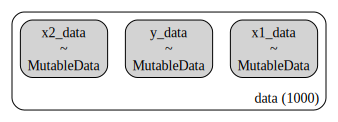

In [20]:
pm.model_to_graphviz(model1)

In [21]:
with model1:
    #事前分布を定義
    
    #切片を標準偏差100の正規分布で定義
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    #x1の傾きを半正規分布で定義
    a1 = pm.HalfNormal("a1", sigma=1)
    #x2の傾きを正規分布で定義
    a2= pm.Normal("a2",mu=0, sigma=1)
    
    #誤差を半正規分布で定義
    epsilon = pm.HalfNormal("epsilon", sigma=1)

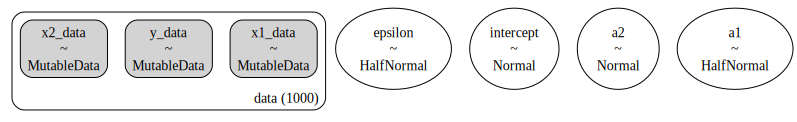

In [22]:
pm.model_to_graphviz(model1)

In [23]:
with model1:
    #観測データ(StudentTを仮定)の平均を計算　重回帰の計算結果が平均となる
    mu = pm.Deterministic("mu", intercept + pt.dot(x1_data, a1) + pt.dot(x2_data,a2), dims=('data',))
    #StudentT分布のパラメータの事前分布を定義
    nu = pm.Gamma("nu",alpha=2,beta=0.1,dims=('data',))
    
    #観測データ(尤度)(StudentTを仮定)を定義
    obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=epsilon, observed=y_data, dims=('data',)) 

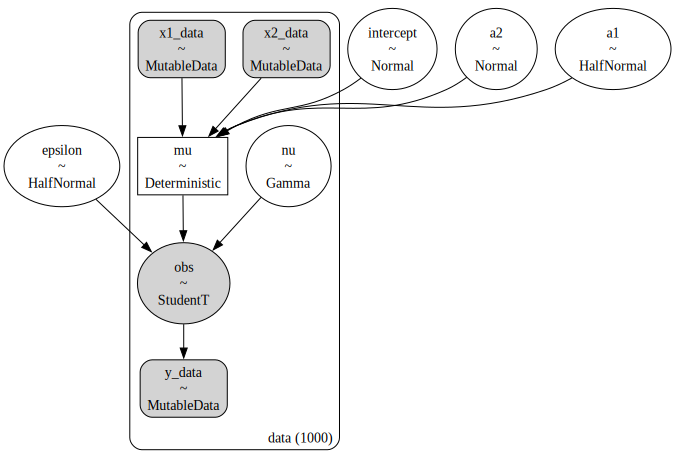

In [24]:
pm.model_to_graphviz(model1)

### 事前分布の妥当性を確認するために事前分布を用いてサンプリング

In [25]:
with model1:
    idata = pm.sample_prior_predictive(samples=1000, random_seed=42)

Sampling: [a1, a2, epsilon, intercept, nu, obs]


/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


(0.0, 1.0)

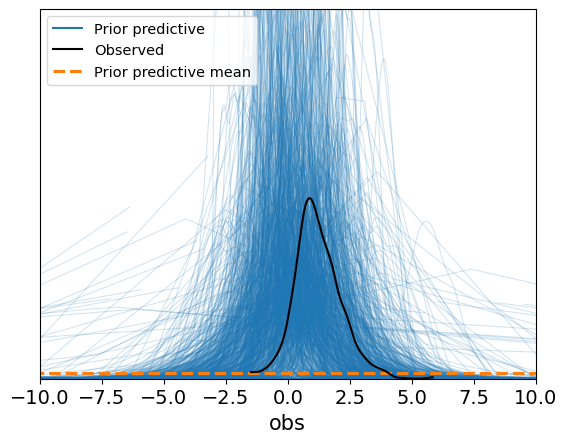

In [26]:
az.plot_ppc(idata, num_pp_samples=1000, group="prior")
plt.xlim(-10, 10)
plt.ylim(0,1)

##### 事前分布と観測データが重なっておりある程度妥当な事前分布と判断できる

#### MCMC実行

In [46]:
#モデル比較のためidata_kwargs={"log_likelihood": True}で対数尤度もサンプルする
with model1:
    idata1 = pm.sample(4000,target_accept=0.95,nuts_sampler="blackjax",random_seed=42,idata_kwargs={"log_likelihood": True},progressbar=True)

Compiling...
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pymc/sampling/jax.py:459: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:01.445698
Sampling...
Sampling time = 0:00:29.340544
Transforming variables...
Transformation time = 0:00:00.245751
Computing Log Likelihood...
Log Likelihood time = 0:00:01.351517


In [47]:
summary1 = az.summary(idata1,var_names=['a1','a2','intercept','epsilon'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.818,0.095,0.643,0.998,0.001,0.001,14094.0,10855.0,1.0
a2,-0.139,0.099,-0.321,0.050,0.001,0.001,14918.0,11827.0,1.0
intercept,0.842,0.071,0.711,0.975,0.001,0.000,10499.0,10952.0,1.0
epsilon,0.813,0.021,0.775,0.853,0.000,0.000,21220.0,12097.0,1.0


In [48]:
#サンプルされたパラメータの事後分布に従ってデータを発生させ、実際のデータ(今回の場合、yの値)と比較
#訓練データを適切に表現できているかを確認する
with model1:
    #事後分布のサンプル
    idata1.extend(pm.sample_posterior_predictive(idata1,random_seed=42))

Sampling: [obs]


In [49]:
# idataの事後予測にobs(事後分布からサンプリングされたデータ)が追加されているか確認
idata1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [31]:
#事後予測のobsの平均値を確認
idata1.posterior_predictive['obs'].mean(dim=['draw', 'chain'])

<xarray.DataArray 'obs' (data: 1000)> Size: 8kB
array([ 1.34280393e+00,  1.58048531e+00,  1.33046522e+03,  5.79150769e-02,
        1.21554573e+00,  7.77313080e-01,  1.49354076e+00,  1.28270655e+00,
       -2.46473580e+00, -1.13988878e+05,  1.04959903e+00,  1.37583115e+00,
        1.35844161e+00,  1.19551635e+00,  1.28904200e+00,  8.47593251e+00,
        1.09536322e+00,  7.68891826e-01,  1.16013316e+00,  1.54296761e+00,
       -9.27267375e+01,  8.15669195e-01, -1.25564167e+04,  1.21412705e+00,
        7.90584695e-02,  6.45315524e-01,  1.31259085e+00,  1.31052634e+00,
       -1.41454718e+00,  1.52058306e+00,  1.35758908e+00,  3.06937455e+00,
        5.28634985e+01, -1.46527239e+03, -3.13819948e+02,  8.40678573e-01,
        1.00075169e+00,  9.06974909e-01,  5.80831189e-01,  1.12055193e+00,
        8.68161328e-01,  8.27563304e-01,  9.62828477e-01,  1.35715545e+00,
        1.20863067e+00,  8.78492309e-01,  1.18937729e+00,  1.29829635e+01,
        1.37935211e+00,  1.41849144e+00, -2.95412521e+12,  1.45905551e+00,
        8.50660907e-01,  1.53425229e+00,  5.65084534e-01,  1.17455466e+00,
        1.35859294e+00,  1.75512752e+00,  1.53726787e+00,  2.25856335e+00,
        2.25578692e+05,  9.00706508e-01,  1.55023902e+00, -2.43917136e+04,
       -2.45037135e+01,  7.60044759e-01,  1.00087592e+00,  9.80327486e-01,
        1.42418542e+00,  1.01033693e+01,  8.75423348e-01,  4.03653859e+01,
       -8.78529414e+00,  8.40691247e-01,  1.19640952e+00,  8.32099924e-01,
       -4.78685418e-01,  1.48903515e+00,  8.67400788e-01,  8.27116309e-01,
...
        1.22680866e+00, -3.15846793e+03,  1.35895638e+00, -9.45151535e+01,
        1.12824346e+00,  1.37566181e+00,  1.35404772e+00,  1.55010555e+00,
        1.12747969e+02,  1.06653858e+00,  8.09179353e-01,  4.55765091e+00,
        4.86948918e+00,  4.13736085e+00,  1.40727330e+17,  1.04314212e+00,
        1.20644545e+05, -1.26357220e+07,  2.21590130e+00,  3.55373739e+00,
        1.48211464e+00,  1.33568027e+00,  1.59647282e+00,  1.40508936e+04,
        9.54474059e-01,  8.28767686e-01,  8.11751140e-01,  1.56509017e+00,
        7.25280677e-01,  1.55962685e+00,  2.90069371e+02,  1.47115880e+00,
        1.05252088e+00,  8.95837490e-01,  2.35245826e-01,  1.30749156e+00,
        5.66013093e-01,  3.25971629e+00, -3.35365900e+00,  1.89086667e+00,
        1.27359865e+00,  1.32805250e+01,  3.63663016e+03,  1.31521482e+00,
       -1.22577149e+09,  3.76830134e+00,  1.33367101e+00,  1.45622963e+00,
        8.21002557e-01, -4.15081565e+03,  1.27592369e+00, -1.07406250e+28,
        6.29355885e-01,  1.38321316e+00,  1.29375154e+00,  1.10227359e+00,
       -1.00596573e+04,  1.43487768e+00,  1.62980149e+00, -3.76315269e+14,
        1.11937233e+00,  1.59361154e+00,  8.64727059e-01, -2.57291885e+01,
        6.16012598e+03,  5.50051410e+04,  1.49563055e+00,  8.03428708e-01,
        4.40190136e+02,  2.77192003e+00,  7.96297388e+00,  3.59863323e+02,
        1.43168031e+00,  8.83305158e-01, -7.66224194e+01,  1.48031066e+00,
       -1.04810928e+01,  7.24920080e-01,  6.38861019e-01,  6.35151579e-01])
Coordinates:
  * data     (data) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


(0.0, 1.0)

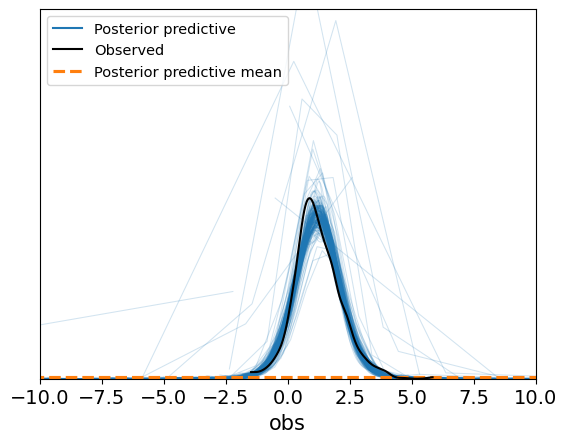

In [50]:
#事後分布からサンプルしたobs(事後予測)を可視化
az.plot_ppc(idata1, num_pp_samples=200)
plt.xlim(-10, 10)
plt.ylim(0,1)

#### 実線が実際のデータ　青い線が事後予測で推定されたモデルはそれなりに妥当と判断できる

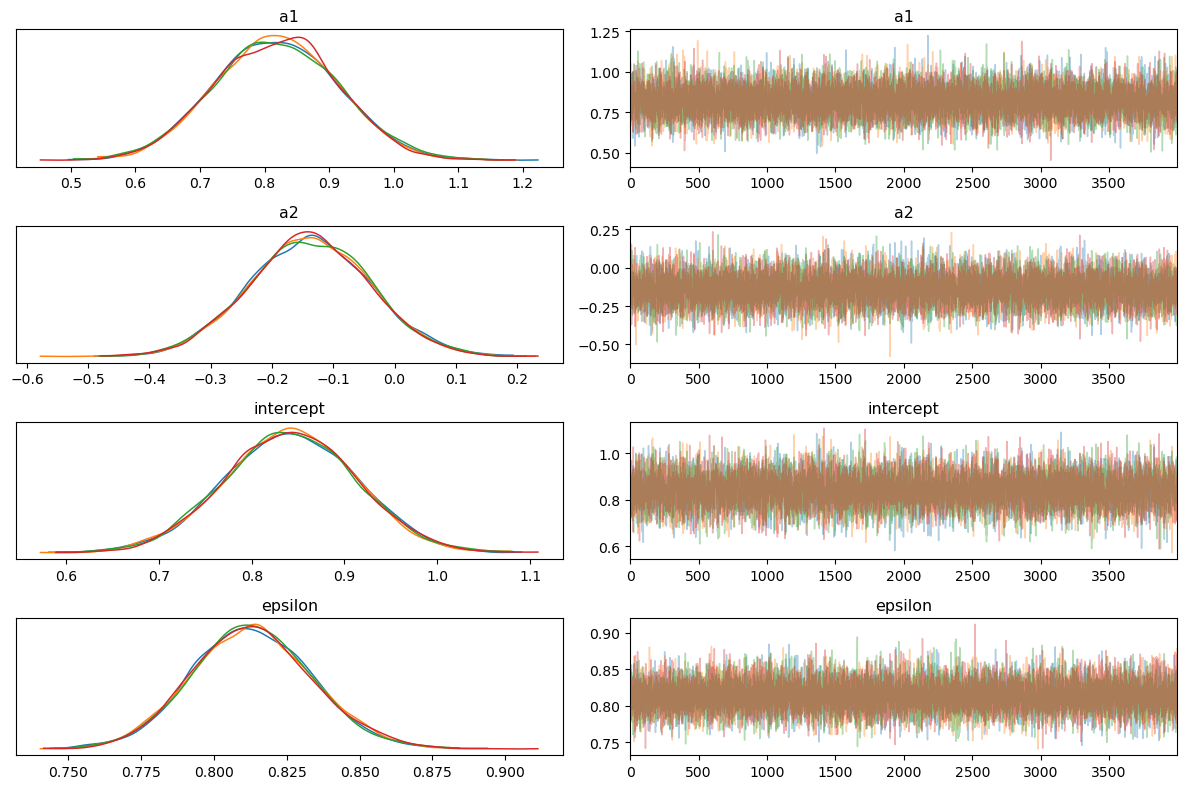

In [51]:
#model1のトレース結果
az.plot_trace(idata1, compact=False, var_names=['a1','a2','intercept','epsilon'])
plt.tight_layout()

array([<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a2'}>,
       <Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

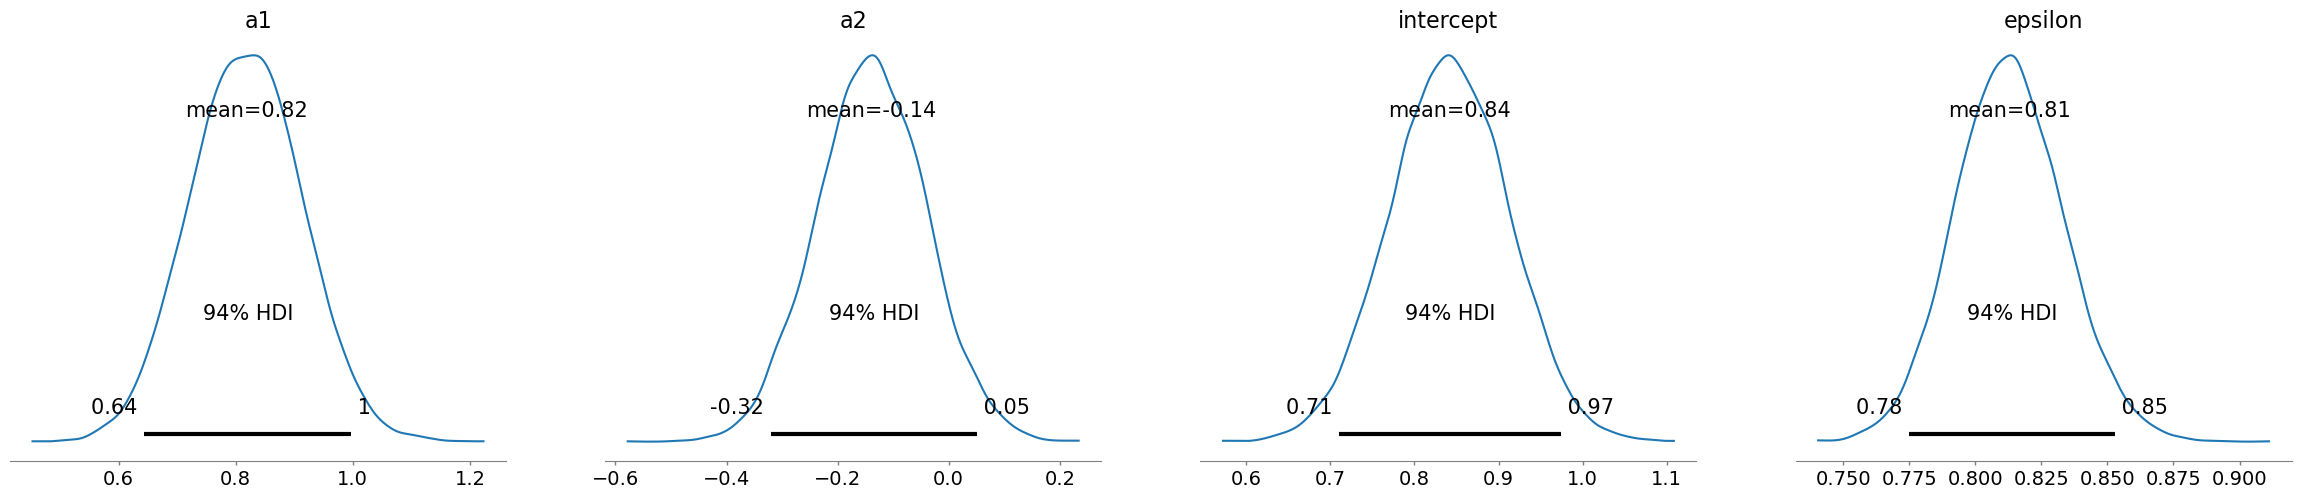

In [52]:
#model1のサンプラーのトレース結果
az.plot_posterior(idata1, var_names=['a1','a2','intercept','epsilon'])

##### Energyプロットを確認  
理想的なプロットとしてはMarginal EnergyとEnergy Transitionの分布が一致している  
一致していればHMCやNUTSは目的としている分布をよくサンプリングできていることを意味する  
Energy Transition分布の方がMarginal Energyの分布より狭い場合、HMCやNUTSは目的としている領域の一部しかサンプリングできていないことを意味する

<Axes: >

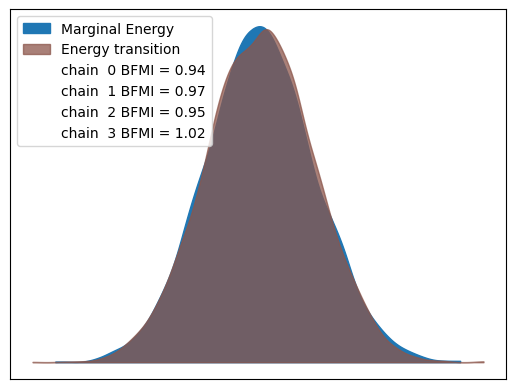

In [53]:
az.plot_energy(idata1)

### MCMCの結果考察  
R_hatが1.0、グラフも定常状態になっているため収束出来ていると判断  
Marginal EnergyとEnergy Transitionの分布もどちらのModelもある程度一致しているためサンプリングもある程度上手くできている

## 真の値とMCMCの結果の比較

In [54]:
a1_true.mean()

0.7989018462742012

In [55]:
a2_true.mean()

0.0008775392649924401

In [56]:
intercept_true.mean()

0.8185138798236967

In [57]:
#model1のa1の平均値
idata1['posterior']['a1'].values.mean()

0.8184244954170156

In [58]:
#model1のa2の平均値
idata1['posterior']['a2'].values.mean()

-0.13871781329288427

In [59]:
idata1['posterior']['intercept'].values.mean()

0.841615524177465

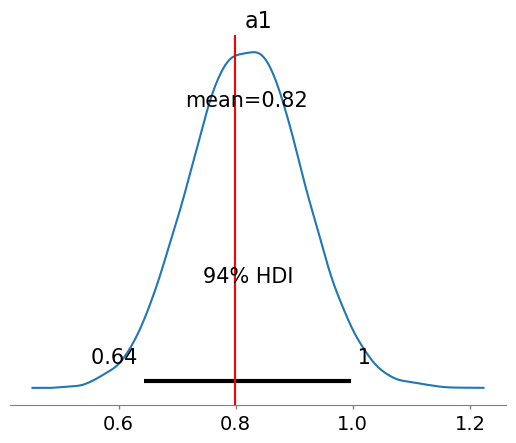

In [60]:
## model1のa1結果確認
az.plot_posterior(idata1, var_names=['a1'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a1_true.mean(),color='red')

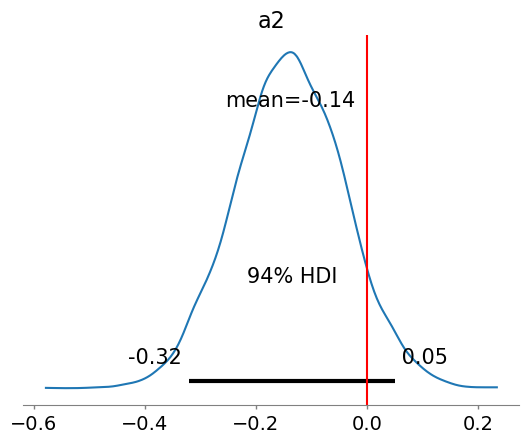

In [61]:
## model1のa2結果確認
az.plot_posterior(idata1, var_names=['a2'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a2_true.mean(),color='red')

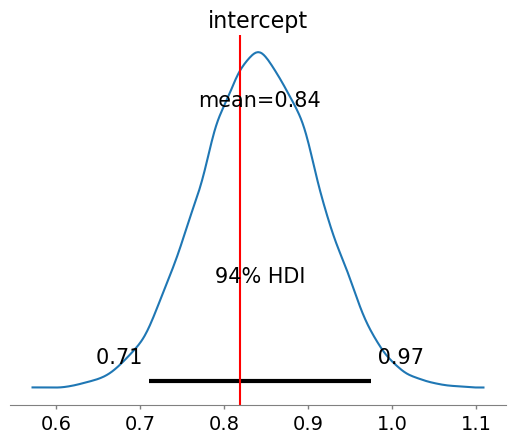

In [62]:
## model1のa2結果確認
az.plot_posterior(idata1, var_names=['intercept'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=intercept_true.mean(),color='red')